# Microbiome Analysis: Age and Menopausal Status Impact

1. Is there correlation between age and diversity (all population, MP status highlighted)?

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from sklearn.manifold import MDS
from skbio.diversity import alpha_diversity, beta_diversity
import statsmodels.api as sm

# Set plotting style
plt.rcParams.update({
    'figure.figsize': [10, 6],
    'figure.dpi': 100,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'font.size': 10
})
sns.set_theme(style="whitegrid")
sns.set_palette('husl')

## Data Preprocessing

/var/folders/4f/5tpkngkd7tb_m0mvrrk7kntc0000gn/T/ipykernel_18732/3996580577.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_non_mp_full['menopausal_status'] = np.nan


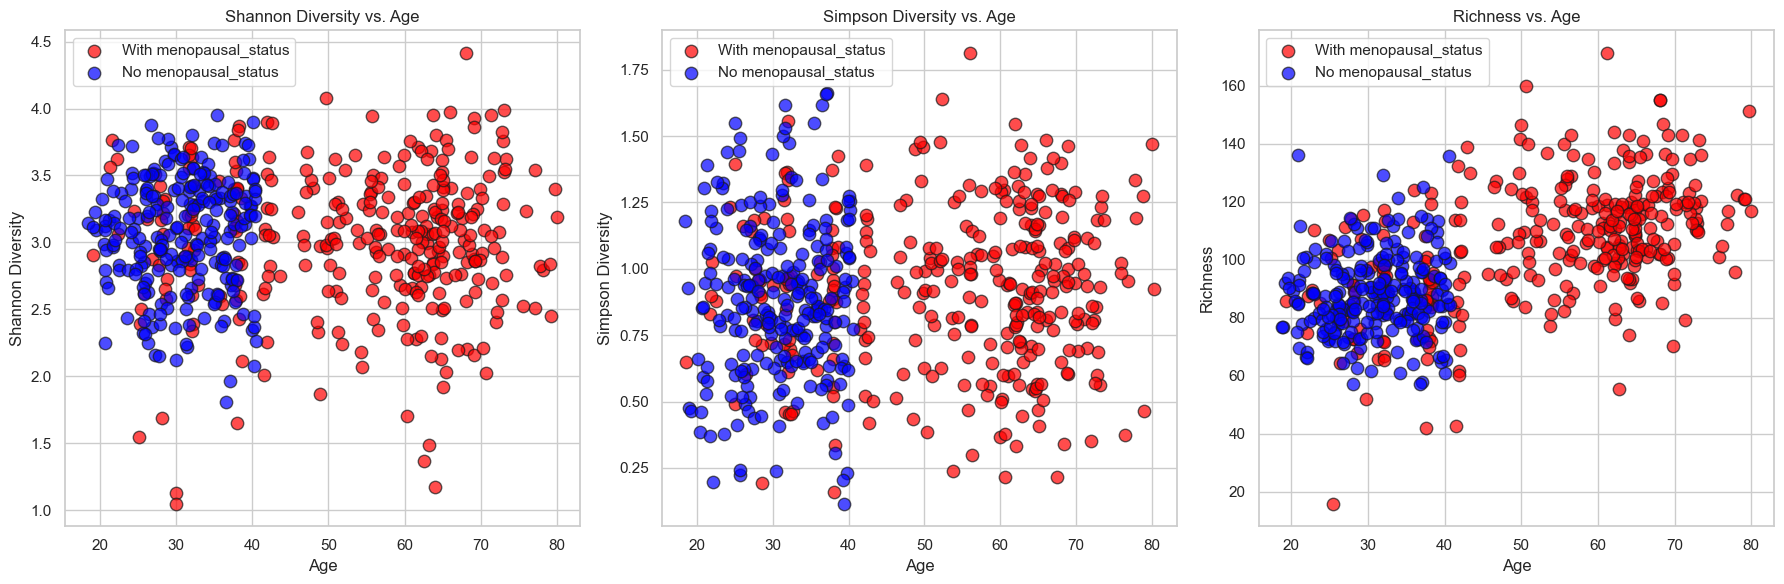

abundance_mp
                                                    NCS-005-Stool-maternal_microbiome  \
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactoba...                                0.0   
k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o...                                0.0   

                                                    NCS-006-Stool-maternal3_microbiome  \
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactoba...                                 0.0   
k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o...                                 0.0   

                                                    NCS-012-Stool-maternal1_microbiome  \
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactoba...                                 0.0   
k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o...                                 0.0   

                                                    NCS-012-Stool-maternal3_microbiome  \
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactoba...                                 0.0 

In [ ]:
from pathlib import Path 

base_path = Path("input")
output_path = Path("figures")
mp_studies = ["ChuDM", "ShaoY", "XieH"]

# all_meta = pd.read_csv(base_path / 'all-curated-MB_meta.csv')
# meta_control = all_meta[
    # (all_meta['gender'] == 'female') & 
    # (all_meta['disease'] == 'healthy') &
    # (all_meta['study_condition'] == 'control') &
    # (all_meta['age_category'] == 'adult') &
    # ((all_meta['body_subsite'] == 'stool') | (all_meta['body_site'] == 'stool')) &
    # (all_meta['pregnant'] != 'yes') &    ## for AsnicarF dataset
    # (all_meta['lactating'] != 'yes') &    ## for AsnicarF dataset
    # (all_meta['antibiotics_current_use'] != 'yes') & 
    # (all_meta['age'] <= 40) &
    # (~all_meta['PMID'].isna())
# ]

# print(meta_control.groupby(['study_name'])
#       .size()
#       .reset_index(name='samples_count')
#       .sort_values(by='samples_count', ascending=False))

metadata_non_mp_raw = pd.read_csv(base_path / 'LifeLinesDeep/LifeLinesDeep_2016_metadata.csv', index_col=0)
abundance_non_mp_raw = pd.read_csv(base_path / 'LifeLinesDeep/LifeLinesDeep_2016_abundance.csv', index_col=0)

abundance_mp_tmp = []
metadata_mp_tmp = []

for study in mp_studies:
    study_path = base_path / study
    try:
        abundance_file = list(study_path.glob("*abundance.csv"))[0]
        abundance = pd.read_csv(abundance_file, index_col=0)
        
        # Load metadata
        metadata_file = list(study_path.glob("*metadata.csv"))[0]
        metadata = pd.read_csv(metadata_file, index_col=0)
        
        abundance_mp_tmp.append(abundance)
        metadata_mp_tmp.append(metadata)
        
    except Exception as e:
        print(f"Error loading {study}: {str(e)}")

abundance_mp_raw = pd.concat(abundance_mp_tmp, axis=1)
metadata_mp_raw = pd.concat(metadata_mp_tmp, axis=0)

# Filter out females with both age and menopausal status
metadata_mp_full = metadata_mp_raw[
    (metadata_mp_raw['gender'] == 'female') & 
    (~metadata_mp_raw['menopausal_status'].isna()) &
    (~metadata_mp_raw['age'].isna()) &
    (metadata_mp_raw['body_site'] == 'stool') &
    (~metadata_mp_raw['PMID'].isna()) 
]

# print(metadata_mp.shape)
abundance_mp = abundance_mp_raw[
            abundance_mp_raw.columns.intersection(metadata_mp_full.index)
        ]
# print(abundance_mp.head(2))

# Filter out females aged <= 40, disease ststus = healthy
metadata_non_mp_full = metadata_non_mp_raw[
    (metadata_non_mp_raw['gender'] == 'female') & 
    (metadata_non_mp_raw['disease'] == 'healthy') &
    (metadata_non_mp_raw['study_condition'] == 'control') &
    (metadata_non_mp_raw['age_category'] == 'adult') &
    # ((metadata_non_mp_raw['body_subsite'] == 'stool') | (metadata_non_mp_raw['body_site'] == 'stool')) &
    (metadata_non_mp_raw['body_site'] == 'stool') &
    # (metadata_non_mp_raw['pregnant'] != 'yes') &    ## for AsnicarF dataset
    # (metadata_non_mp_raw['lactating'] != 'yes') &    ## for AsnicarF dataset
    (metadata_non_mp_raw['antibiotics_current_use'] != 'yes') & 
    (metadata_non_mp_raw['age'] <= 40) &
    (~metadata_non_mp_raw['PMID'].isna())
]
metadata_non_mp_full['menopausal_status'] = np.nan

abundance_non_mp = abundance_non_mp_raw[
            abundance_non_mp_raw.columns.intersection(metadata_non_mp_full.index)
        ]

diversity_metrics_mp = pd.DataFrame(index=abundance_mp.columns)
diversity_metrics_non_mp = pd.DataFrame(index=abundance_non_mp.columns)

# Shannon diversity
def shannon_diversity(x):
    x = x[x > 0]
    return -np.sum(x * np.log(x))
diversity_metrics_mp['shannon'] = abundance_mp.apply(
    lambda x: shannon_diversity(x/100)
)

def shannon_diversity(x):
    x = x[x > 0]
    return -np.sum(x * np.log(x))
diversity_metrics_non_mp['shannon'] = abundance_non_mp.apply(
    lambda x: shannon_diversity(x/100)
)

# Simpson diversity
def simpson_diversity(x):
    return 1 - np.sum(x ** 2)
diversity_metrics_mp['simpson'] = abundance_mp.apply(
    lambda x: simpson_diversity(x/100)
)

def simpson_diversity(x):
    return 1 - np.sum(x ** 2)
diversity_metrics_non_mp['simpson'] = abundance_non_mp.apply(
    lambda x: simpson_diversity(x/100)
)

# Species richness
diversity_metrics_mp['richness'] = (abundance_mp > 0).sum()
diversity_metrics_mp = diversity_metrics_mp.merge(
    metadata_mp_full[['age', 'menopausal_status']],
    left_index=True,
    right_index=True
)

diversity_metrics_non_mp['richness'] = (abundance_non_mp > 0).sum()
diversity_metrics_non_mp = diversity_metrics_non_mp.merge(
    metadata_non_mp_full[['age', 'menopausal_status']],
    left_index=True,
    right_index=True
)

results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

abundance_mp.to_csv(results_dir / "abundance_matrix_mp.csv")
metadata_mp_full.to_csv(results_dir / "metadata_mp.csv")
abundance_mp.to_csv(results_dir / "abundance_matrix_mp.csv")
metadata_non_mp_full.to_csv(results_dir / "metadata_non_mp.csv")

df_all = pd.concat([diversity_metrics_mp.reset_index(), diversity_metrics_non_mp.reset_index()], ignore_index=True)
is_mp = df_all['menopausal_status'].notna()

summary_stats = {
    'total_mp_samples': abundance_mp.shape[1],
    'total_mp_species': abundance_mp.shape[0],
    'mp_samples_per_group': metadata_mp_full['menopausal_status'].value_counts().to_dict(),
    'mp_age_summary': metadata_mp_full['age'].describe().to_dict(),

    'total_non_mp_samples': abundance_non_mp.shape[1],
    'total_non_mp_species': abundance_non_mp.shape[0],
    'non_mpsamples_per_group': metadata_non_mp_full['menopausal_status'].value_counts().to_dict(),
    'non_mp_age_summary': metadata_non_mp_full['age'].describe().to_dict(),

    'menopausal_status_groups': list(metadata_mp_full['menopausal_status'].unique())
}

with open(output_path / "exp/initial_dataset_summary.txt", 'w') as f:
    f.write("Initial Dataset Summary\n")
    f.write("=====================\n\n")
    f.write(f"Total samples menopausal status: {summary_stats['total_mp_samples']}\n")
    f.write(f"Total samples non-menopausal status: {summary_stats['total_non_mp_samples']}\n")
    f.write(f"Total species menopausal group: {summary_stats['total_mp_species']}\n")
    f.write(f"Total species non-menopausal group: {summary_stats['total_non_mp_species']}\n")
    f.write("\nMenopausal status groups: {}\n".format(
        ', '.join(summary_stats['menopausal_status_groups'])
    ))
    
    f.write("\nSamples per group:\n")
    for group, count in summary_stats['mp_samples_per_group'].items():
        f.write(f"  {group}: {count}\n")
    
    f.write("\nAge summary:\n")
    for stat, value in summary_stats['mp_age_summary'].items():
        f.write(f"  {stat}: {value:.2f}\n")

In [ ]:
def jitter(arr, stdev=0.3):
    return arr + np.random.normal(0, stdev, size=arr.shape)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Shannon Diversity vs. Age
axes[0].scatter(
    jitter(df_all.loc[is_mp, 'age']),
    jitter(df_all.loc[is_mp, 'shannon']),
    color='red', label='With menopausal_status', alpha=0.7, edgecolor='k', s=80
)
axes[0].scatter(
    jitter(df_all.loc[~is_mp, 'age']),
    jitter(df_all.loc[~is_mp, 'shannon']),
    color='blue', label='No menopausal_status', alpha=0.7, edgecolor='k', s=80
)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Shannon Diversity')
axes[0].set_title('Shannon Diversity vs. Age')
axes[0].legend()

# Simpson Diversity vs. Age
axes[1].scatter(
    jitter(df_all.loc[is_mp, 'age']),
    jitter(df_all.loc[is_mp, 'simpson']),
    color='red', label='With menopausal_status', alpha=0.7, edgecolor='k', s=80
)
axes[1].scatter(
    jitter(df_all.loc[~is_mp, 'age']),
    jitter(df_all.loc[~is_mp, 'simpson']),
    color='blue', label='No menopausal_status', alpha=0.7, edgecolor='k', s=80
)
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Simpson Diversity')
axes[1].set_title('Simpson Diversity vs. Age')
axes[1].legend()

# Richness vs. Age
axes[2].scatter(
    jitter(df_all.loc[is_mp, 'age']),
    jitter(df_all.loc[is_mp, 'richness']),
    color='red', label='With menopausal_status', alpha=0.7, edgecolor='k', s=80
)
axes[2].scatter(
    jitter(df_all.loc[~is_mp, 'age']),
    jitter(df_all.loc[~is_mp, 'richness']),
    color='blue', label='No menopausal_status', alpha=0.7, edgecolor='k', s=80
)
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Richness')
axes[2].set_title('Richness vs. Age')
axes[2].legend()

plt.tight_layout()
plt.savefig(output_path / 'exp/diversity_vs_age.png')
plt.show()
plt.close()

In [ ]:
# concat metadata
metadata_all = pd.concat([metadata_mp_full, metadata_non_mp_full], axis=0)
metadata_all['age'] = pd.to_numeric(metadata_all['age'], errors='coerce')

# merge MP groups into 'menopausal', treat NaN/empty as 'control'
metadata_all['menopausal_status'] = metadata_all['menopausal_status'].replace('', np.nan)
metadata_all['menopausal_status'] = np.where(
    metadata_all['menopausal_status'].isna(), 'control', 'menopausal'
)

# One-hot encode menopausal_status (collect 'control' and 'menopausal' columns)
menopausal_dummies = pd.get_dummies(metadata_all['menopausal_status'])

# concat abundance
abundance_all = pd.concat([abundance_mp, abundance_non_mp], axis=1)

# perform regression per bacteria

results = []

for bacterium in abundance_all.index:
    y = abundance_all.loc[bacterium]
    # Build predictors
    X = metadata_all[['age']].copy()
    # Add menopausal_status dummies
    for col in menopausal_dummies.columns:
        X[col] = menopausal_dummies[col]
    # Add intercept
    X = sm.add_constant(X)
    # Ensure all predictors and y are numeric
    X = X.apply(pd.to_numeric, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')

    # Only drop rows with missing y or age (not menopausal_status, since filled)
    valid = (~y.isna()) & (~X['age'].isna())
    y_valid = y[valid]
    X_valid = X.loc[valid]

    # Drop any rows with NaN in predictors or response
    valid_rows = (~y_valid.isna()) & (~X_valid.isna().any(axis=1))
    X_valid = X_valid.loc[valid_rows]
    y_valid = y_valid.loc[valid_rows]

    # Make all columns to float
    X_valid = X_valid.astype(float)
    y_valid = y_valid.astype(float)

    if len(y_valid) < 3:  # Not enough data to fit
        continue
    # Fit model
    model = sm.OLS(y_valid, X_valid)
    res = model.fit()
    
    # Collect results
    result_row = {
        'B_i': bacterium,
        'intercept': res.params.get('const', np.nan),
        'age_coef': res.params.get('age', np.nan),
        'menopausal_coef': res.params.get('menopausal', np.nan),
        'menopausal_pval': res.pvalues.get('menopausal', np.nan)
    }
    results.append(result_row)

results_df = pd.DataFrame(results) 

# apply Bonferroni correction
n_tests = len(results_df)
results_df['menopausal_pval_bonf'] = results_df['menopausal_pval'] * n_tests
results_df['menopausal_pval_bonf'] = results_df['menopausal_pval_bonf'].clip(upper=1.0)

# min p-value among menopausal status for each bacterium
results_df['min_menopausal_pval'] = results_df['menopausal_pval_bonf']

# Sort by smallest menopausal_status p-value
results_df = results_df.sort_values('min_menopausal_pval')

display_cols = ['B_i', 'intercept', 'age_coef', 'menopausal_coef', 'menopausal_pval_bonf', 'min_menopausal_pval']
print(results_df[display_cols].head(5))

                                                   B_i  intercept  age_coef  \
307  k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   0.442658 -0.006693   
215  k__Bacteria|p__Proteobacteria|c__Deltaproteoba...   0.042381 -0.000711   
141  k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   2.752068 -0.014343   
275  k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   0.762463 -0.009019   
495  k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   0.199211 -0.005629   
147  k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   0.007220 -0.000227   
261  k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   0.328845 -0.010200   
386  k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   0.481151  0.010198   
137  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   0.010032 -0.000315   
549  k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   0.213537 -0.005420   

     menopausal_coef  menopausal_pval_bonf  min_menopausal_pval  
307         0.585139          2.071381e-24         2.071381e-24 

In [ ]:
# select top/bottom bacteria(15% from each side)
n = int(len(results_df) * 0.15)
coef_col = 'menopausal_coef'

# drop rows with NaN for coef
filtered_df = results_df.dropna(subset=[coef_col])

sorted_df = filtered_df.sort_values(coef_col)
bottom_15 = sorted_df.head(n)
top_15 = sorted_df.tail(n)
selected_bacteria = pd.concat([bottom_15, top_15])

print("Bottom 15% (most negative correlation):")
print(bottom_15[['B_i', coef_col, 'min_menopausal_pval']])

print("\nTop 15% (most positive correlation):")
print(top_15[['B_i', coef_col, 'min_menopausal_pval']])

Bottom 15% (most negative correlation):
                                                   B_i  menopausal_coef  \
228  k__Bacteria|p__Verrucomicrobia|c__Verrucomicro...        -1.611819   
183  k__Bacteria|p__Actinobacteria|c__Actinobacteri...        -0.814472   
191  k__Bacteria|p__Actinobacteria|c__Coriobacterii...        -0.751377   
302  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...        -0.423924   
400  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...        -0.423780   
..                                                 ...              ...   
848  k__Bacteria|p__Proteobacteria|c__Deltaproteoba...        -0.000564   
97   k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...        -0.000558   
543  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...        -0.000530   
378  k__Bacteria|p__Actinobacteria|c__Actinobacteri...        -0.000517   
53   k__Bacteria|p__Actinobacteria|c__Coriobacterii...        -0.000510   

     min_menopausal_pval  
228                  1.0  
183  

/var/folders/4f/5tpkngkd7tb_m0mvrrk7kntc0000gn/T/ipykernel_18732/2088664036.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volcano_df['neg_log10_pval'] = -np.log10(volcano_df[pval_col])


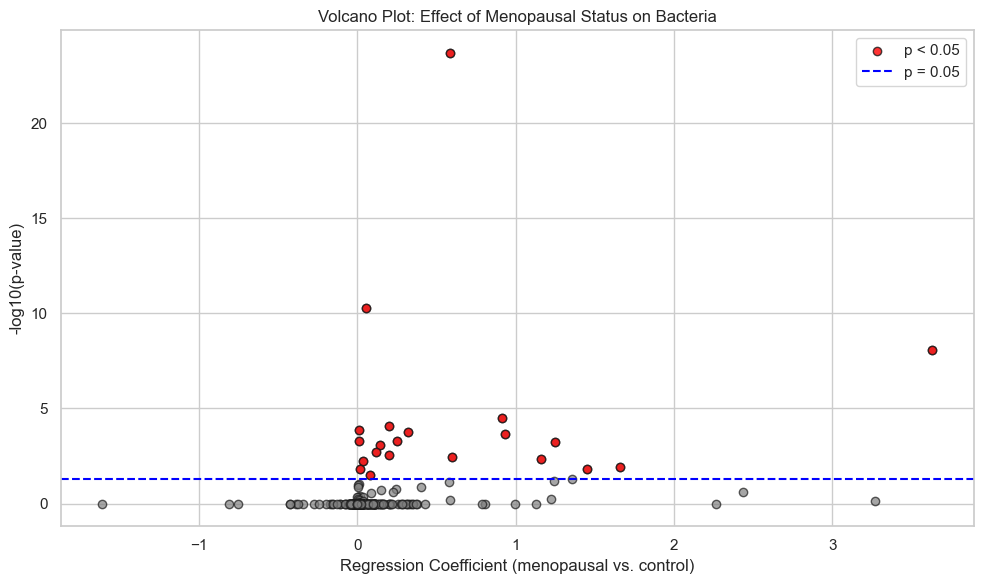

In [ ]:
# coeffs to plot for MP
coef_col = 'menopausal_coef'
pval_col = 'menopausal_pval_bonf'

# drop rows with NaN for coeffs
volcano_df = results_df.dropna(subset=[coef_col, pval_col])

# adjust p-value to -log10(p-value)
volcano_df['neg_log10_pval'] = -np.log10(volcano_df[pval_col])

plt.figure(figsize=(10, 6))

# x = coefficient, y = -log10(p-value)
plt.scatter(
    volcano_df[coef_col],
    volcano_df['neg_log10_pval'],
    c='grey', alpha=0.7, edgecolor='k'
)

# Highlight points with p < 0.05
sig = volcano_df[pval_col] < 0.05
plt.scatter(
    volcano_df.loc[sig, coef_col],
    volcano_df.loc[sig, 'neg_log10_pval'],
    c='red', alpha=0.8, edgecolor='k', label='p < 0.05'
)

## Annotate top 3 significant bacteria
# top_hits = volcano_df[sig].sort_values(pval_col).head(3)
# for _, row in top_hits.iterrows():
#     plt.text(row[coef_col], row['neg_log10_pval'], row['B_i'], fontsize=8)

plt.axhline(-np.log10(0.05), color='blue', linestyle='--', label='p = 0.05')
plt.xlabel('Regression Coefficient (menopausal vs. control)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: Effect of Menopausal Status on Bacteria')
plt.legend()
plt.tight_layout()
plt.savefig(output_path / 'exp/volcano_bacteria_per_mp_status.png')
plt.show()

with open(output_path / "exp/top_3_bacteria.txt", 'w') as f:
    f.write(top_hits.to_string(index=False))